In [41]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt
import seaborn as sns

In [42]:
# Separate EEG data into chunks corresponding to each image
# Constants
EEG_SAMPLING_RATE = 125  # Hz
EEG_COLUMNS = ['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'F7', 'F8', 'F3', 'F4', 'T7', 'T8', 'P3', 'P4']

# Load EEG data
eeg_df = pd.read_csv('datos_raw/output_file_Ian-Carbajal-m-23-202411071724.csv')

# Load timestamps
timestamps_df = pd.read_csv('datos_raw/timestamps_Ian-Carbajal-m-23-202411071724.csv', header=None, names=['Song', 'Timestamp'])

# Add a column for end time of each image
timestamps_df['EndTimestamp'] = timestamps_df['Timestamp'].shift(-1)

# no stimuli index
no_stimuli_index = 0


In [43]:
for i in range(0,80,2):
    timestamps_df.loc[i,"Timestamp"]=timestamps_df.loc[i,"Timestamp"]-30

for i in range(1,79,2):
    timestamps_df.loc[i,"EndTimestamp"]=timestamps_df.loc[i+1,"Timestamp"]

In [44]:
timestamps_df

,Song,Timestamp,EndTimestamp
0,songs/pop/pop.00011.wav,0.994617,30.994779
1,no_stimuli,30.994779,33.994610
2,songs/pop/pop.00012.wav,33.994610,63.994849
3,no_stimuli,63.994849,66.994270
4,songs/pop/pop.00023.wav,66.994270,96.994469
...,...,...,...
75,no_stimuli,1251.995279,1254.994578
76,songs/metal/metal.00077.wav,1254.994578,1284.994804
77,no_stimuli,1284.994804,1287.994463
78,songs/metal/metal.00096.wav,1287.994463,1317.994696


In [45]:
# Iterate over the timestamps and separate EEG data
for index, row in timestamps_df.iterrows():
    start_time = row['Timestamp']
    end_time = row['EndTimestamp'] if not pd.isna(row['EndTimestamp']) else timestamps_df['Timestamp'].iloc[-1]

    # Calculate the corresponding indices in the EEG data
    start_index = int(start_time * EEG_SAMPLING_RATE)
    end_index = int(end_time * EEG_SAMPLING_RATE)

    # Get the chunk of EEG data
    eeg_chunk = eeg_df.iloc[start_index:end_index]

    # Determine the category or no stimuli
    if 'no_stimuli' in row['Song']:
        chunk_label = 'no_stimuli'
        song_index = no_stimuli_index
        no_stimuli_index += 1
    else:
        chunk_label = row['Song'].split('/')[1]  # Extract category from the path
        song_index = row['Song'].split('/')[2].split('.')[1]

    # Save to a new CSV
    eeg_chunk.to_csv(f'processed_data/eeg_data_{chunk_label}_{song_index}.csv', index=False)

In [46]:
# Plotting functions
def plot_in_grid(plots, grid_shape):
    """
    Plots a list of matplotlib plots in a grid layout.

    Parameters:
    - plots: A list of matplotlib plots.
    - grid_shape: A tuple (rows, columns) specifying the grid layout.
    """

    # Ensure that the number of plots does not exceed the grid capacity
    if len(plots) > grid_shape[0] * grid_shape[1]:
        raise ValueError("Number of plots exceeds the grid capacity")

    # Create a new figure
    plt.figure(figsize=(12, 8))

    # Iterate over the plots and add them to the grid
    for i, plot in enumerate(plots):
        # Add a new subplot in the correct position
        ax = plt.subplot(grid_shape[0], grid_shape[1], i + 1)

        # Draw the plot in the subplot
        plot(ax)

    # Show the final layout
    plt.tight_layout()
    plt.show()

def plot_eeg_data_separate_plots(eeg_data):
    '''
    Plots all of the channels of the EEG data in separate plots
    Params:
        eeg_data: pandas DataFrame with the EEG data
    '''
    eeg_columns = eeg_data.columns
    fig, axs = plt.subplots(len(eeg_columns), 1, figsize=(10, 10))
    for i, column in enumerate(eeg_columns):
        axs[i].plot(eeg_data[column])
        axs[i].set_title(column)
        axs[i].set_xlabel('Time (ms)')
        axs[i].set_ylabel('Amplitude (uV)')
    plt.show()

def plot_eeg_data_same_plot(eeg_data, centered=False, plot=False):
    def plot_func(ax):
        eeg_columns = eeg_data.columns
        for column in eeg_columns:
            if centered:
                ax.plot(eeg_data[column] - np.mean(eeg_data[column]), label=column)
            else:
                ax.plot(eeg_data[column], label=column)

        title = 'Centered EEG data' if centered else 'EEG data'
        ax.set_title(title)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Amplitude (uV)')
        ax.legend(loc='upper right')

    if plot:
        fig, ax = plt.subplots(figsize=(10, 10))
        plot_func(ax)
        plt.show()
    else:
        return plot_func

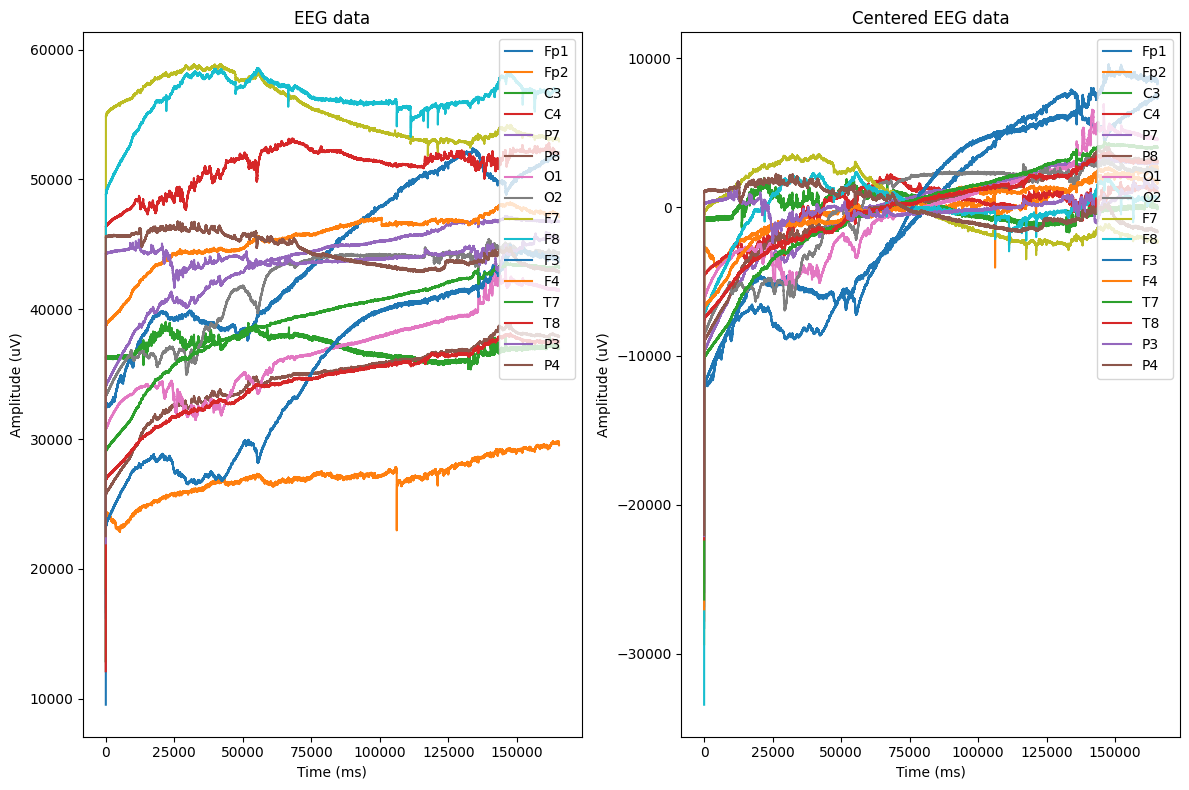

In [47]:
plot_in_grid([plot_eeg_data_same_plot(eeg_df),
            plot_eeg_data_same_plot(eeg_df, centered=True)], 
            (1, 2))

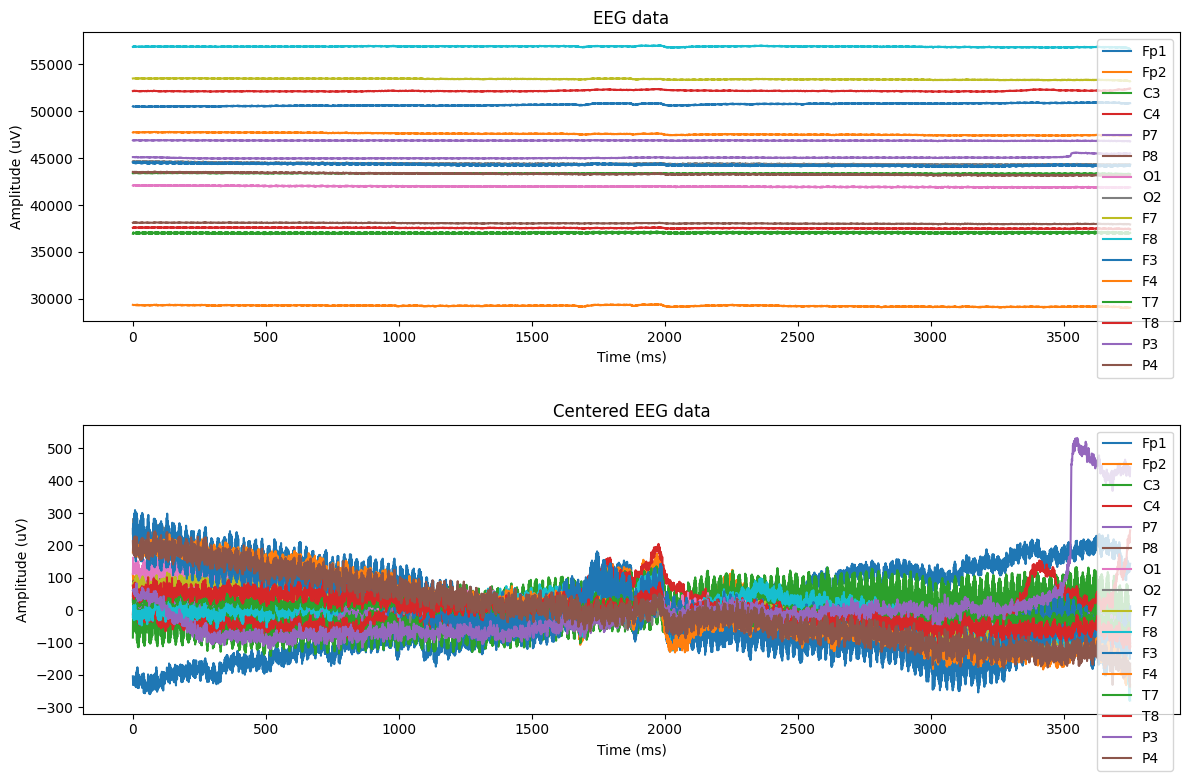

In [48]:
cat = pd.read_csv('processed_data/eeg_data_metal_00068.csv')
plot_in_grid([plot_eeg_data_same_plot(cat),
            plot_eeg_data_same_plot(cat, centered=True)], 
            (2, 1))

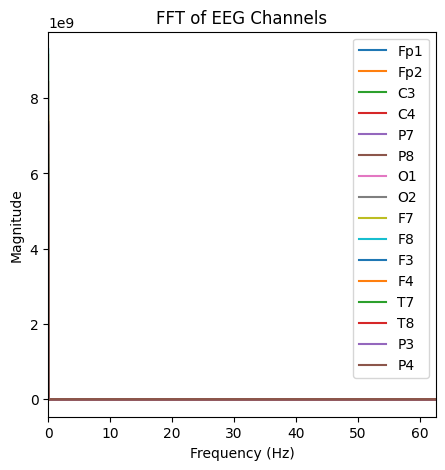

In [49]:
def plot_eeg_fft(eeg_data, plot=False):
    def plot_func(ax):
        sampling_rate = 125
        N = len(eeg_data)  # Number of data points

        for column in eeg_data.columns:
            # Compute FFT
            fft_values = np.fft.fft(eeg_data[column])
            frequencies = np.fft.fftfreq(N, 1/sampling_rate)

            # Plot the magnitude of the FFT
            ax.plot(frequencies, np.abs(fft_values), label=column)

        ax.set_title('FFT of EEG Channels')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Magnitude')
        ax.set_xlim(0, sampling_rate / 2)  # Limit x-axis to positive frequencies
        ax.legend()

    if plot:
        fig, ax = plt.subplots(figsize=(5, 5))
        plot_func(ax)
        plt.show()
    else:
        return plot_func

plot_eeg_fft(eeg_df, plot=True)

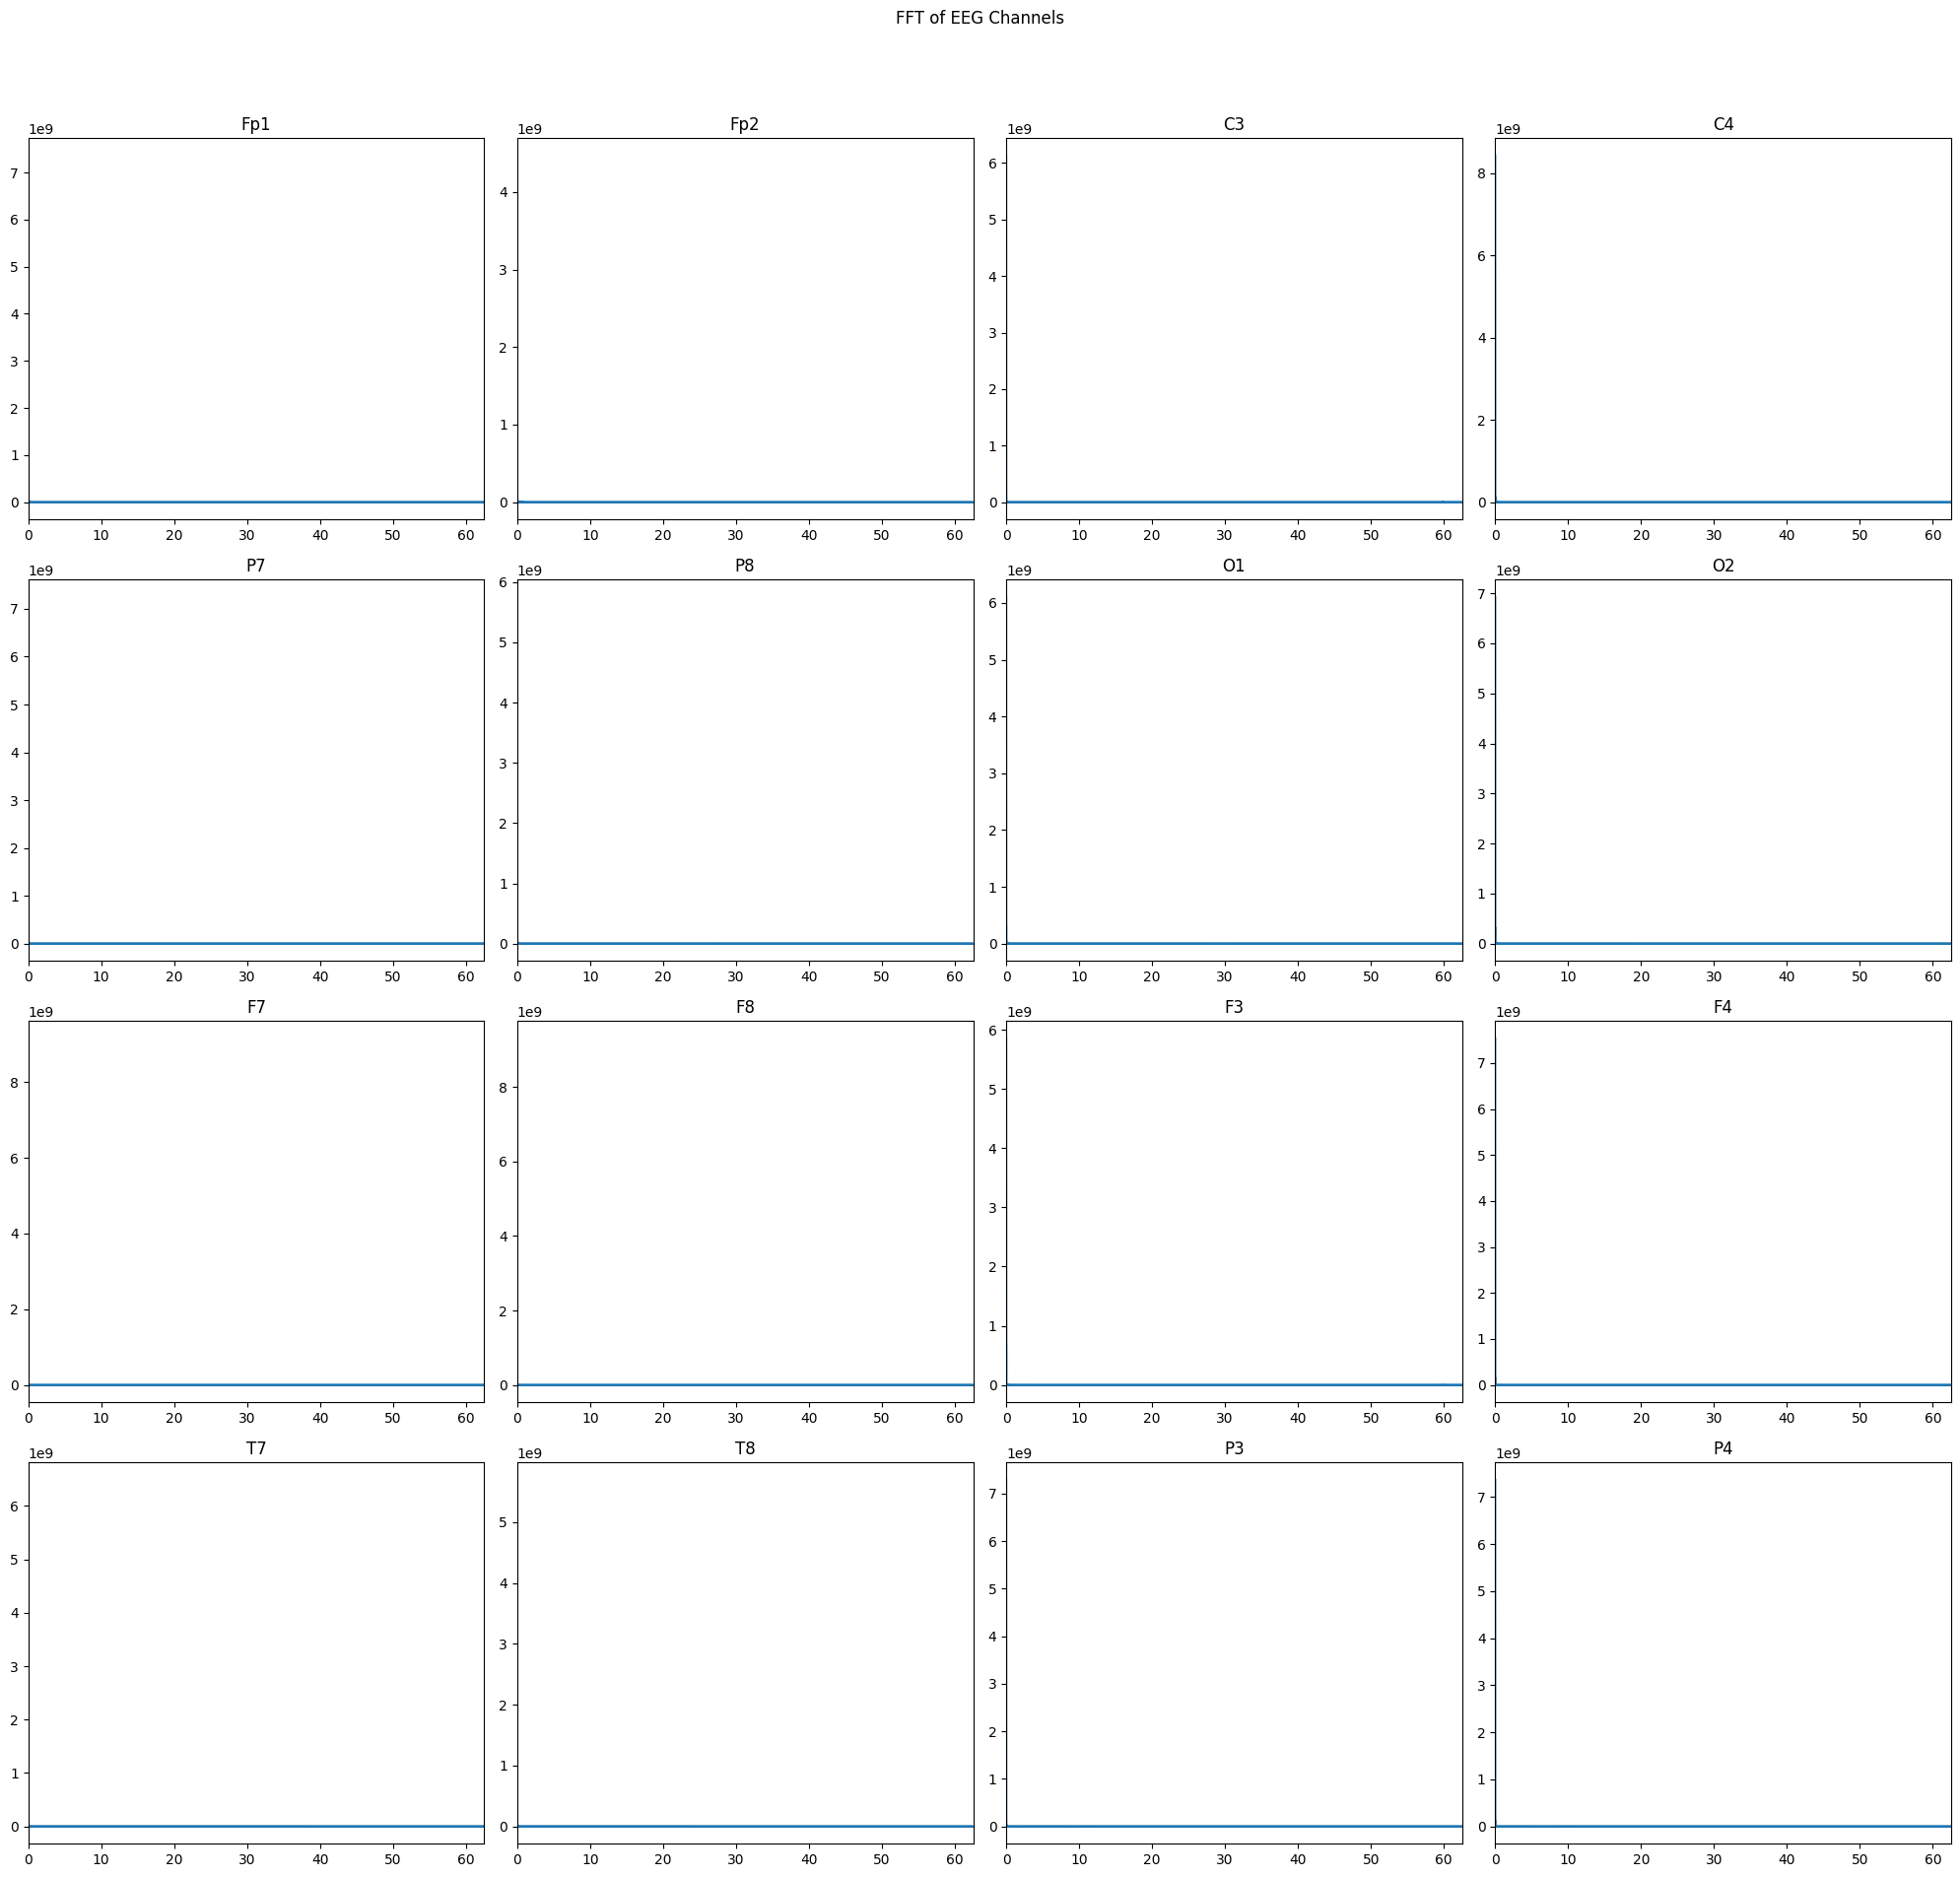

In [50]:
def plot_eeg_fft_grid(eeg_data):
    '''
    Plots the Fast Fourier Transform of each channel of the EEG data in a 3x4 grid.
    Params: 
        eeg_data: pandas DataFrame with the EEG data
    '''
    eeg_columns = eeg_data.columns
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))  # 4 rows, 4 columns grid of plots
    fig.suptitle('FFT of EEG Channels')

    sampling_rate = 125  
    N = len(eeg_data)  # Number of data points

    for i, column in enumerate(eeg_columns):
        # Compute FFT
        fft_values = np.fft.fft(eeg_data[column])
        frequencies = np.fft.fftfreq(N, 1/sampling_rate)

        # Determine the row and column to place the subplot
        row = i // 4
        col = i % 4

        # Plot the magnitude of the FFT in the appropriate subplot
        axs[row, col].plot(frequencies, np.abs(fft_values))
        axs[row, col].set_title(column)
        axs[row, col].set_xlim(0, sampling_rate / 2)  # Limit x-axis to positive frequencies

    # Adjust layout to prevent overlap of subplot titles and axes labels
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_eeg_fft_grid(eeg_df)


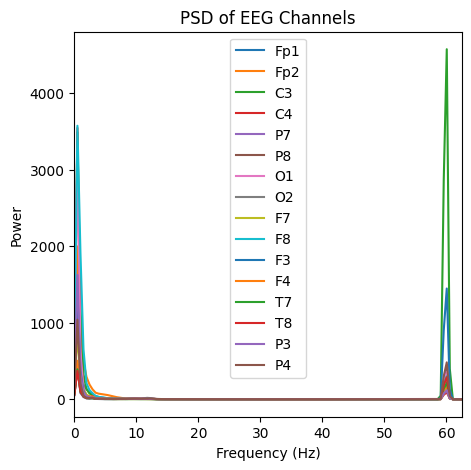

In [51]:
def plot_eeg_psd(eeg_data, plot=False):
    def plot_func(ax):
        sampling_rate = 125
        N = len(eeg_data)  # Number of data points

        for column in eeg_data.columns:
            # Compute PSD
            frequencies, psd_values = welch(eeg_data[column], fs=sampling_rate)

            # Plot the magnitude of the PSD
            ax.plot(frequencies, psd_values, label=column)

        ax.set_title('PSD of EEG Channels')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power')
        ax.set_xlim(0, sampling_rate / 2)  # Limit x-axis to positive frequencies
        ax.legend()

    if plot:
        fig, ax = plt.subplots(figsize=(5, 5))
        plot_func(ax)
        plt.show()
    else:
        return plot_func

plot_eeg_psd(eeg_df, plot=True)

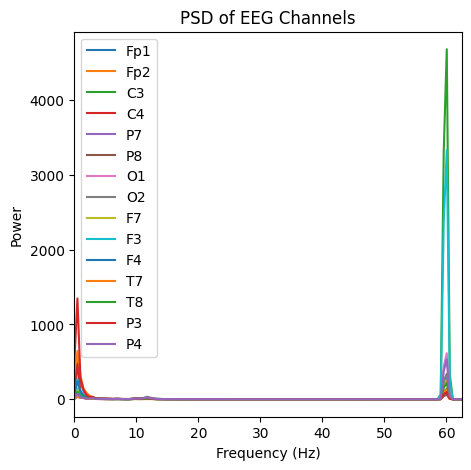

In [52]:
plot_eeg_psd(cat.drop(['F8'], axis=1), plot=True)

In [53]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 125  # Example sample rate
lowcut = 1.0
highcut = 60.0

# Function to design a Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to apply the bandpass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass_filter_df(data, around_cero=False, lowcut=1.0, highcut=60.0, fs=125, order=5):
    '''
    Applies a bandpass filter to each column of the input DataFrame and adds the original unfiltered mean
    Params:
        data: pandas DataFrame with the data to filter
        around_cero: boolean indicating whether to add the original unfiltered mean (default: False)
        lowcut: low cutoff frequency of the bandpass filter
        highcut: high cutoff frequency of the bandpass filter
        fs: sampling rate of the data
        order: order of the Butterworth filter
    '''
    filtered_data = pd.DataFrame()
    if around_cero:
        for column in data.columns:
            filtered_data[column] = butter_bandpass_filter(data[column], lowcut, highcut, fs, order=order)
    else:
        for column in data.columns:
            filtered_data[column] = butter_bandpass_filter(data[column], lowcut, highcut, fs, order=order)\
                                    + np.mean(data[column])
    return filtered_data

# Apply the bandpass filter to the EEG data
filtered_eeg_df = butter_bandpass_filter_df(eeg_df)
filtered_eeg_df_centered = butter_bandpass_filter_df(eeg_df, around_cero=True)

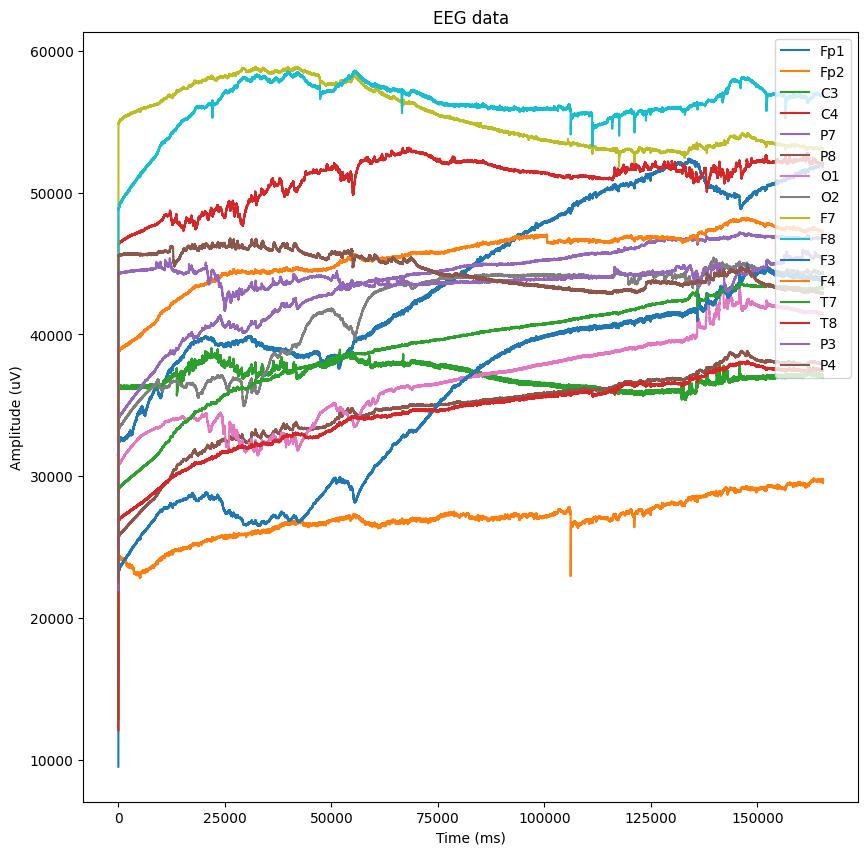

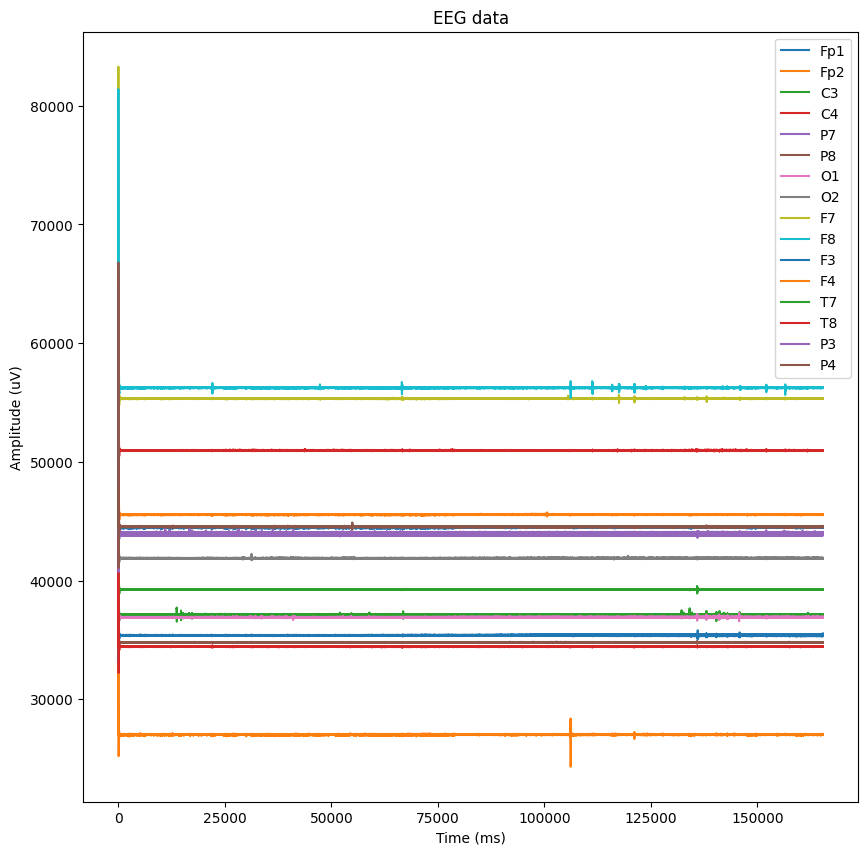

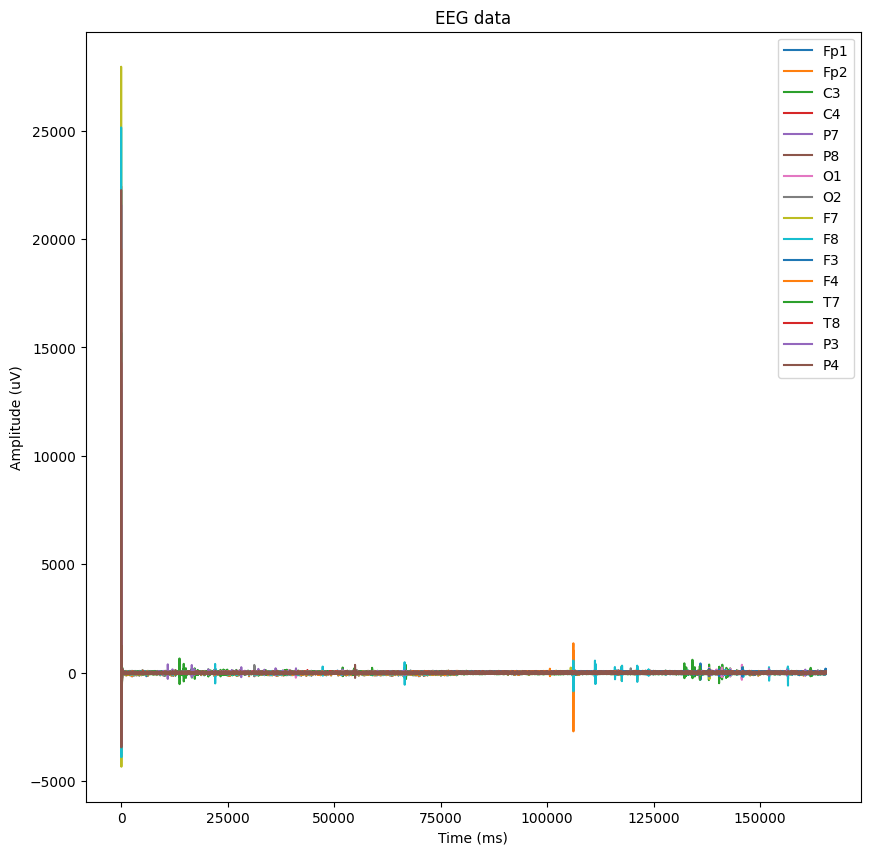

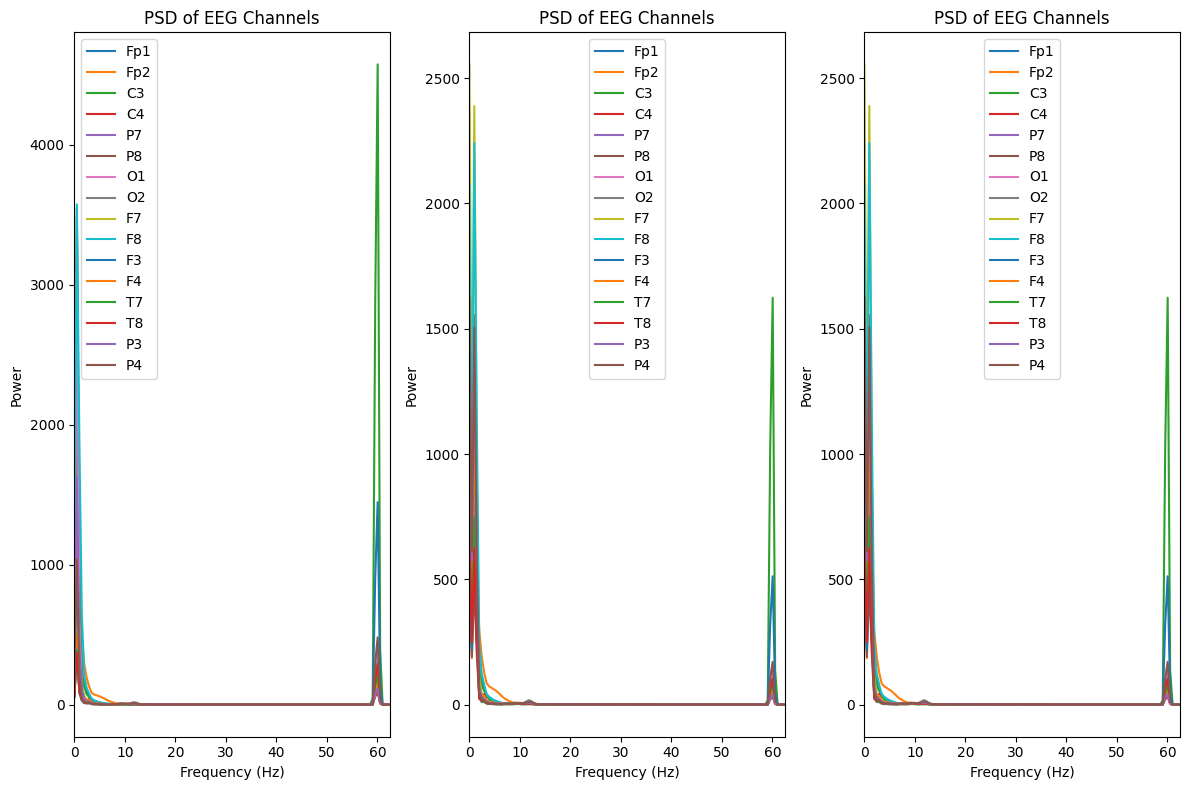

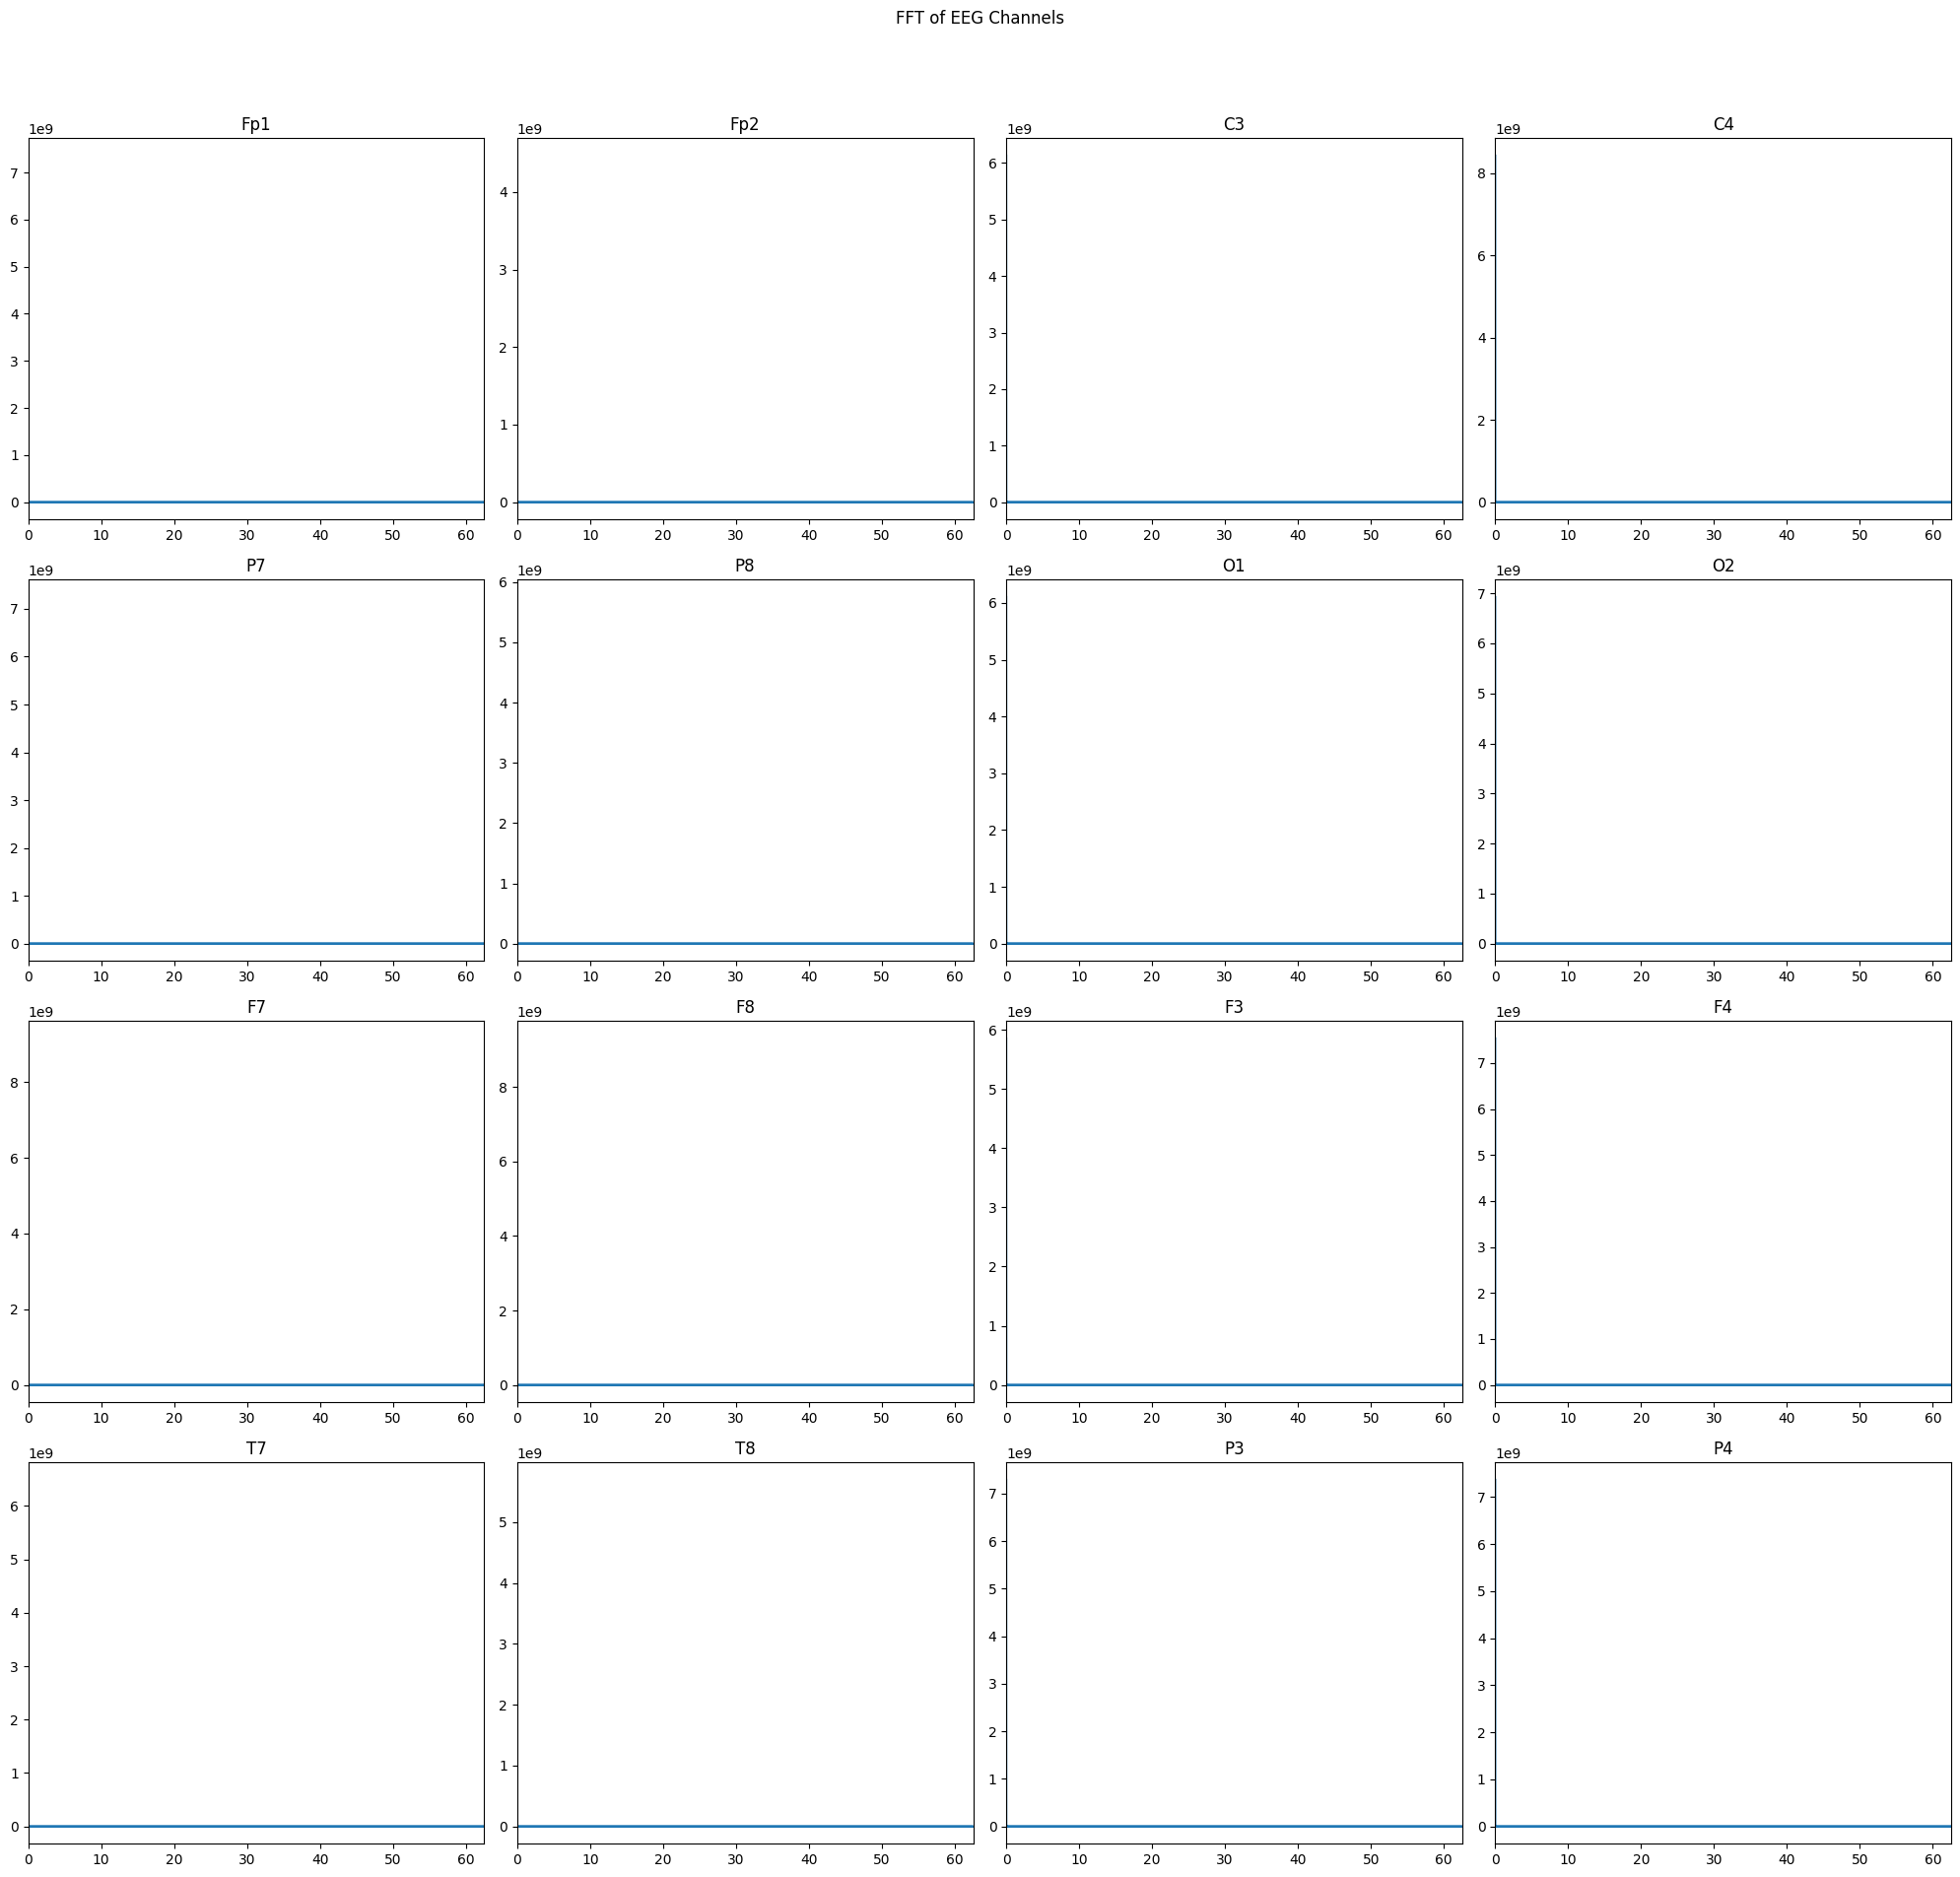

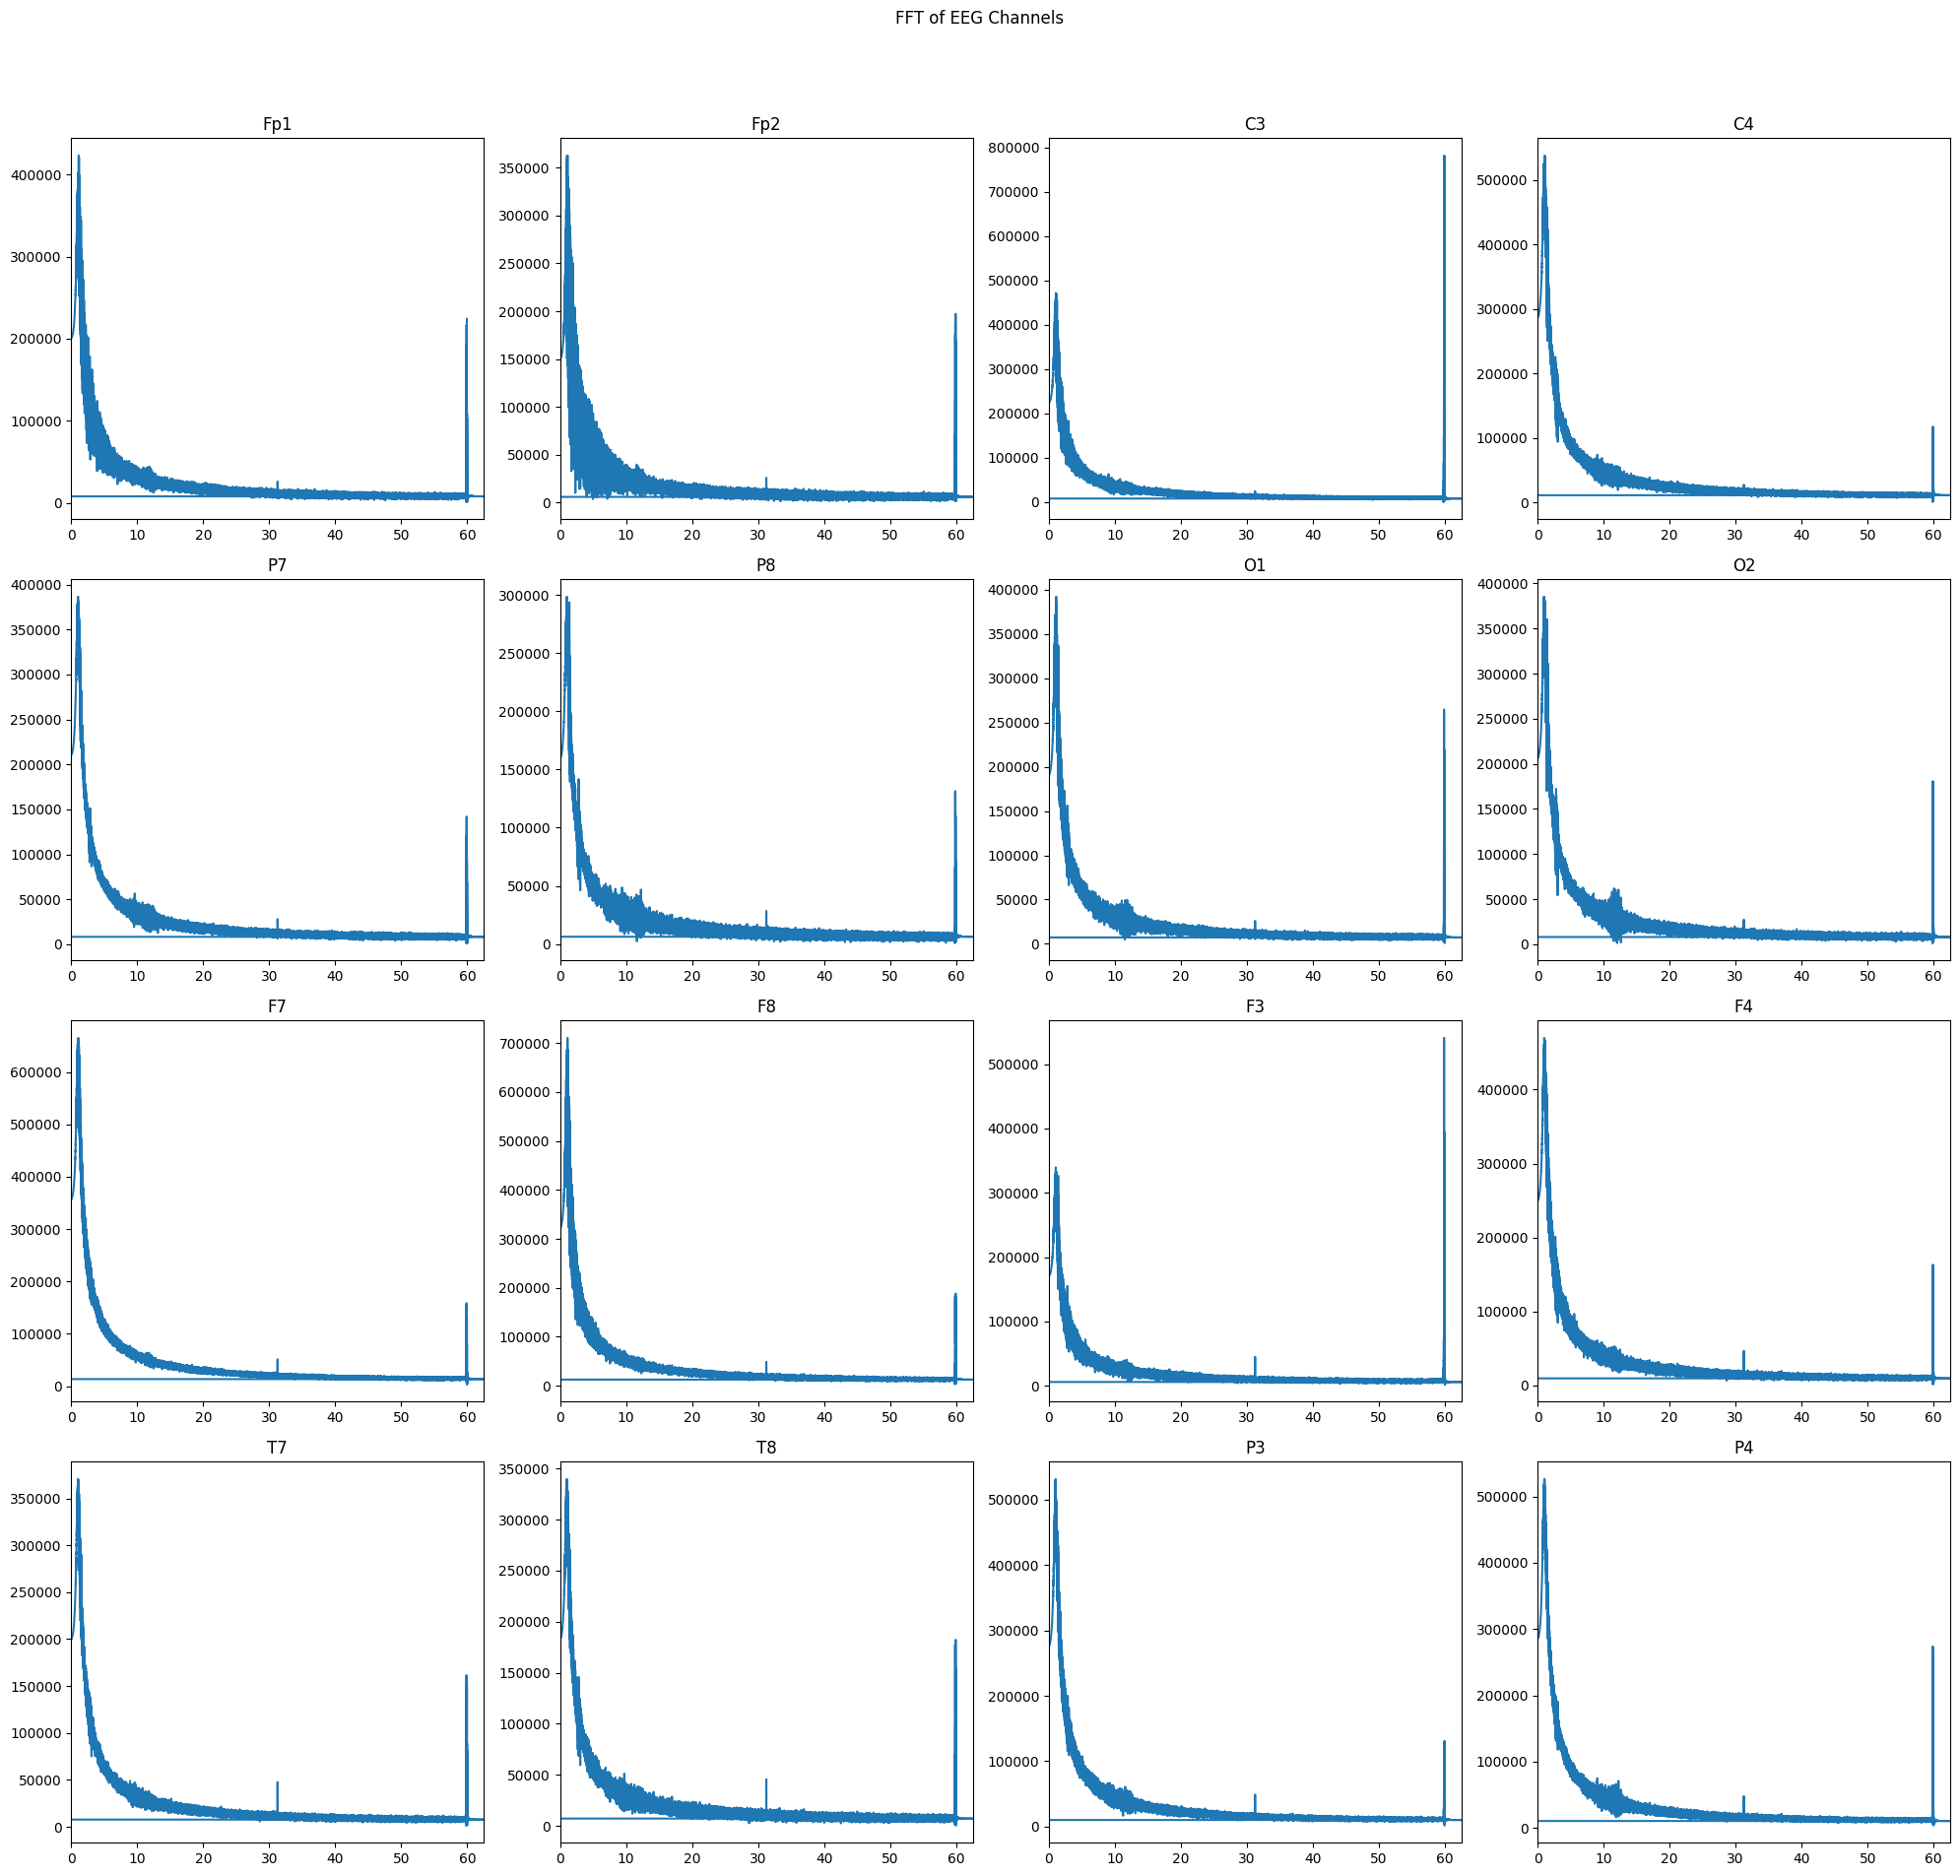

In [54]:
# Plot the filtered data
plot_eeg_data_same_plot(eeg_df, plot=True)
plot_eeg_data_same_plot(filtered_eeg_df, plot=True)
plot_eeg_data_same_plot(filtered_eeg_df_centered, plot=True)

# Plot the psd of the filtered data
plot_in_grid([plot_eeg_psd(eeg_df),
            plot_eeg_psd(filtered_eeg_df),
            plot_eeg_psd(filtered_eeg_df_centered)], 
            (1, 3))

plot_eeg_fft_grid(filtered_eeg_df)
plot_eeg_fft_grid(filtered_eeg_df_centered)

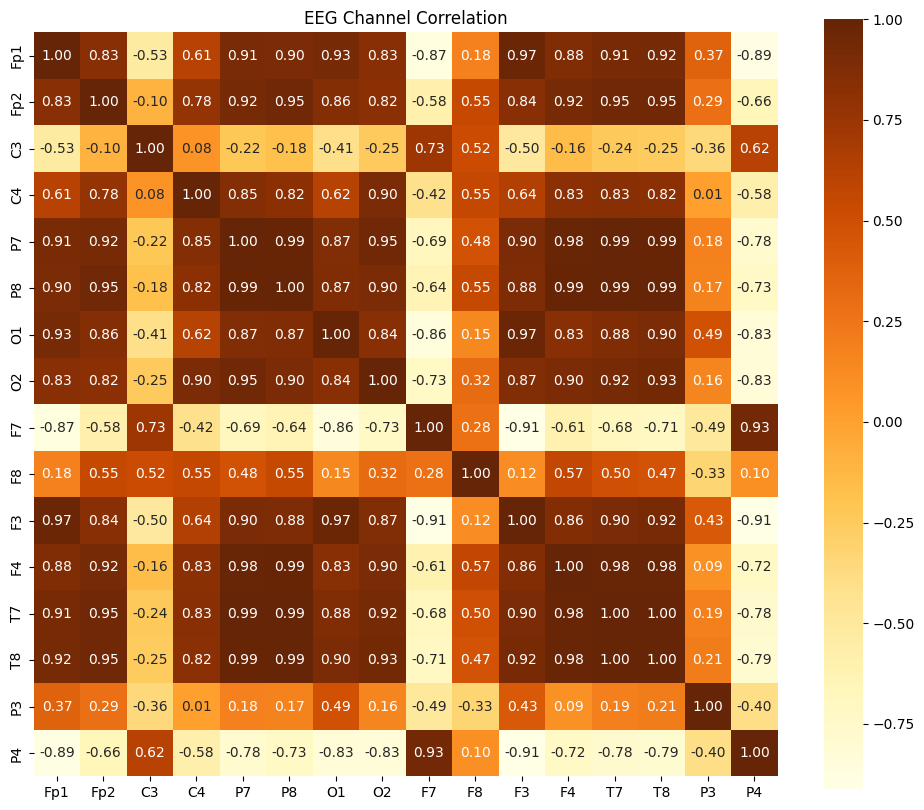

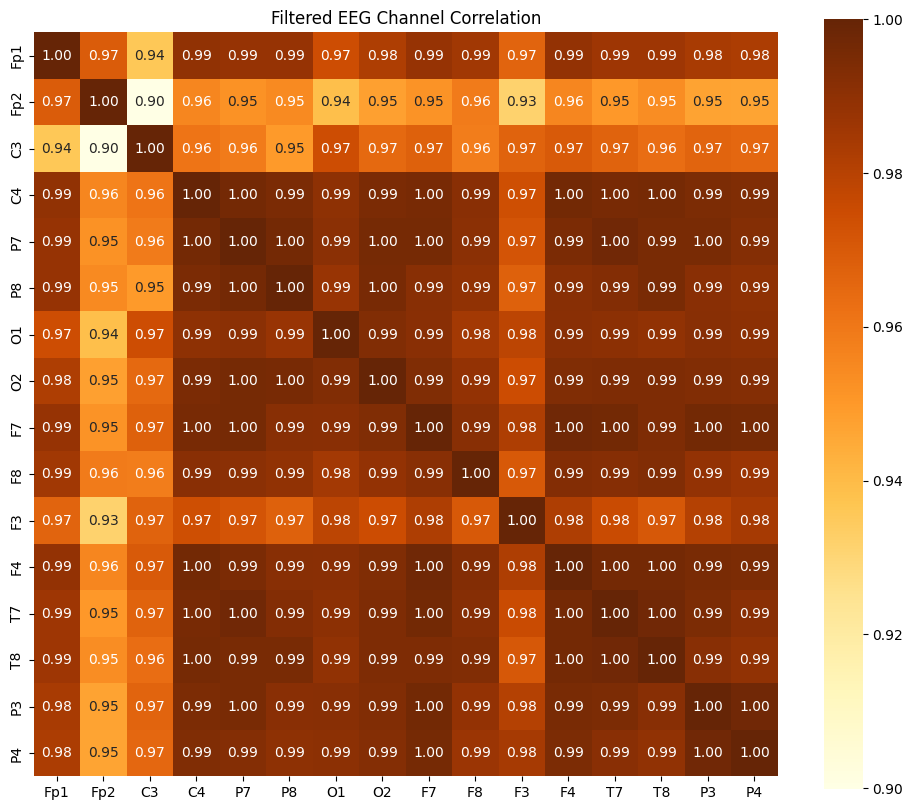

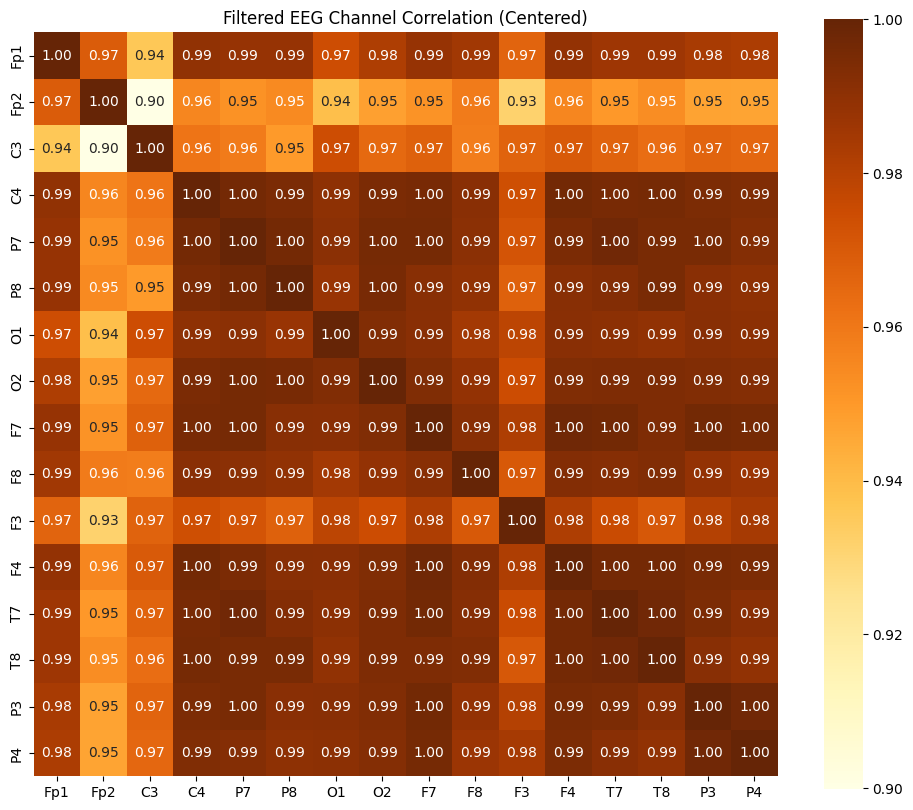

In [55]:
def plot_correlation_matrix(eeg_data, cmap='coolwarm', title='EEG Channel Correlation'):
    plt.figure(figsize=(12, 10))
    sns.heatmap(eeg_data.corr(), annot=True, fmt=".2f", square=True, cmap=cmap)
    plt.title(title)
    plt.show()

plot_correlation_matrix(eeg_df, cmap='YlOrBr')
plot_correlation_matrix(filtered_eeg_df, cmap='YlOrBr', title='Filtered EEG Channel Correlation')
plot_correlation_matrix(filtered_eeg_df_centered, cmap='YlOrBr', title='Filtered EEG Channel Correlation (Centered)')